# **[Chapter 01]**  
**┗ 의류 판매량 예측**
---
> **목차(Context)**

* 문제상황 및 데이터 살펴보기
* 문제해결 프로세스 정의
* 🥉Session 1 - 「Data 전처리 및 EDA」
* 🥈Session 2 - 「시계열 데이터 모델링」
* 🥇Session 3 - 「Random Forest 모델링」

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
!git add .
!git commit -m "Update"

fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git


# **문제상황 및 데이터 살펴보기**
---
> **시나리오** 🏭

```
A 의류 회사에서는 생산량을 조절하기 위해서 판매량을 예측하려 한다.
의류의 종류에 따라 계절성을 많이 타기 때문에, 이러한 특성을 고려할 수 있는 모델링이 필요하다.
일단, 데이터 살펴보면서 의류 판매량 예측을 진행해보도록 하자.
```



> **데이터 살펴보기**

* 일자별 의류 판매량
* 데이터 명세 ⬇

|Column|Description|
|:---|:---|
|SEASON|SS, AW|
|TYPE|국내, 해외 등|
|2016-01-01|날짜..|
|...||
|2019-12-31|날짜..|

In [ ]:
!pip install -r /content/drive/MyDrive/DS-case-study/Clothing_Sales/requirements.txt

In [2]:
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

data_path = "/content/drive/MyDrive/DS-case-study/[01]Data/"
df = pd.read_excel(data_path + 'WEAR_TS_ALL.xlsx')
df.head()

,SEASON,TYPE,2016-01-01 00:00:00,2016-01-02 00:00:00,2016-01-03 00:00:00,2016-01-04 00:00:00,2016-01-05 00:00:00,2016-01-06 00:00:00,2016-01-07 00:00:00,2016-01-08 00:00:00,2016-01-09 00:00:00,2016-01-10 00:00:00,2016-01-11 00:00:00,2016-01-12 00:00:00,2016-01-13 00:00:00,2016-01-14 00:00:00,2016-01-15 00:00:00,2016-01-16 00:00:00,2016-01-17 00:00:00,2016-01-18 00:00:00,2016-01-19 00:00:00,2016-01-20 00:00:00,2016-01-21 00:00:00,2016-01-22 00:00:00,2016-01-23 00:00:00,2016-01-24 00:00:00,2016-01-25 00:00:00,2016-01-26 00:00:00,2016-01-27 00:00:00,2016-01-28 00:00:00,2016-01-29 00:00:00,2016-01-30 00:00:00,2016-01-31 00:00:00,2016-02-01 00:00:00,2016-02-02 00:00:00,2016-02-03 00:00:00,2016-02-04 00:00:00,2016-02-05 00:00:00,2016-02-06 00:00:00,2016-02-07 00:00:00,2016-02-08 00:00:00,2016-02-09 00:00:00,2016-02-10 00:00:00,2016-02-11 00:00:00,2016-02-12 00:00:00,2016-02-13 00:00:00,2016-02-14 00:00:00,2016-02-15 00:00:00,2016-02-16 00:00:00,2016-02-17 00:00:00,...,2019-11-12 00:00:00,2019-11-13 00:00:00,2019-11-14 00:00:00,2019-11-15 00:00:00,2019-11-16 00:00:00,2019-11-17 00:00:00,2019-11-18 00:00:00,2019-11-19 00:00:00,2019-11-20 00:00:00,2019-11-21 00:00:00,2019-11-22 00:00:00,2019-11-23 00:00:00,2019-11-24 00:00:00,2019-11-25 00:00:00,2019-11-26 00:00:00,2019-11-27 00:00:00,2019-11-28 00:00:00,2019-11-29 00:00:00,2019-11-30 00:00:00,2019-12-01 00:00:00,2019-12-02 00:00:00,2019-12-03 00:00:00,2019-12-04 00:00:00,2019-12-05 00:00:00,2019-12-06 00:00:00,2019-12-07 00:00:00,2019-12-08 00:00:00,2019-12-09 00:00:00,2019-12-10 00:00:00,2019-12-11 00:00:00,2019-12-12 00:00:00,2019-12-13 00:00:00,2019-12-14 00:00:00,2019-12-15 00:00:00,2019-12-16 00:00:00,2019-12-17 00:00:00,2019-12-18 00:00:00,2019-12-19 00:00:00,2019-12-20 00:00:00,2019-12-21 00:00:00,2019-12-22 00:00:00,2019-12-23 00:00:00,2019-12-24 00:00:00,2019-12-25 00:00:00,2019-12-26 00:00:00,2019-12-27 00:00:00,2019-12-28 00:00:00,2019-12-29 00:00:00,2019-12-30 00:00:00,2019-12-31 00:00:00
0,16SS,국내,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,16SS,국내,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,6.0,4.0,1.0,3.0,5.0,6.0,2.0,9.0,2.0,7.0,4.0,5.0,3.0,19.0,18.0,13.0,3.0,6.0,16.0,19.0,14.0,23.0,3.0,2.0,11.0,13.0,13.0,10.0,18.0,30.0,10.0,13.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,16SS,국내,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,1.0,2.0,3.0,1.0,3.0,1.0,1.0,6.0,2.0,12.0,14.0,1.0,7.0,3.0,8.0,5.0,11.0,1.0,NaN,11.0,9.0,4.0,5.0,10.0,4.0,5.0,6.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16SS,국내,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,1.0,NaN,7.0,6.0,8.0,4.0,9.0,5.0,1.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,16SS,국내,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,1.0,2.0,1.0,3.0,4.0,9.0,2.0,NaN,4.0,6.0,3.0,1.0,8.0,1.0,4.0,2.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [3]:
df.shape

(515, 1463)

# **Data Spec Check**
---
> **Data 가공 명세서**

<img src = "https://drive.google.com/uc?id=15mCoX5yKTp3yFgjdNEDKz2wcU-iHn61Q">

# **문제해결 프로세스 정의**
---
> **문제정의**

```
▶ 회사에서 재고에 대한 걱정이 늘어나고 있다.
판매량을 알 수 있다면 재고 비용을 비약적으로 줄일 수 있을 것으로 기대하고 있다.
판매량 예측 모델을 만들어보자.
```  

> **기대효과**

```
▶ 의류 시장에서의 큰 비용 중에 하나는 재고 비용이다. 적정 생산량을 통해 재고 비용을 줄일 수 있다.
```

> **해결방안**

```
▶ 시계열 예측을 통한 판매량 예측, RandomForest를 활용한 판매량 예측
▶ Session 1 🥉
 - Data Preprocessing
 - Data Visualization
▶ Session 2 🥈
 - 시계열 예측 모델링
▶ Session 3 🥇
 - RandomForest Regression을 통한 모델링
```

> **성과측정**  

```
▶ 실제 판매량과 예측량의 차이
```

> **현업적용**  

```
▶ 시계열 특성을 가진 데이터를 만났을 때, 접근할 수 있는 방법 체득
```

> **주요 핵심 미리 살펴보기**  

```
▶ Session 1 → Data Preprocessing, Data Visualization
▶ Session 2 → 시계열 예측 모델링
▶ Session 3 → RandomForest Regression 모델링
```

# 🥉Session 1 - 「Data 전처리 및 EDA」

## · Data 전처리  
---
* 수집된 데이터의 기본 정보들을 확인  

  (1) Data shape(형태) 확인

  (2) Data type 확인

  (3) Null값 확인 (※ 빈 값의 Data)


In [4]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import rc
from matplotlib.dates import date2num

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

np.random.seed(0)

In [5]:
import mxnet as mx
mx.random.seed(0)


In [6]:
ts_df = pd.read_excel(data_path + 'WEAR_TS_ALL.xlsx')
ts_df

,SEASON,TYPE,2016-01-01 00:00:00,2016-01-02 00:00:00,2016-01-03 00:00:00,2016-01-04 00:00:00,2016-01-05 00:00:00,2016-01-06 00:00:00,2016-01-07 00:00:00,2016-01-08 00:00:00,2016-01-09 00:00:00,2016-01-10 00:00:00,2016-01-11 00:00:00,2016-01-12 00:00:00,2016-01-13 00:00:00,2016-01-14 00:00:00,2016-01-15 00:00:00,2016-01-16 00:00:00,2016-01-17 00:00:00,2016-01-18 00:00:00,2016-01-19 00:00:00,2016-01-20 00:00:00,2016-01-21 00:00:00,2016-01-22 00:00:00,2016-01-23 00:00:00,2016-01-24 00:00:00,2016-01-25 00:00:00,2016-01-26 00:00:00,2016-01-27 00:00:00,2016-01-28 00:00:00,2016-01-29 00:00:00,2016-01-30 00:00:00,2016-01-31 00:00:00,2016-02-01 00:00:00,2016-02-02 00:00:00,2016-02-03 00:00:00,2016-02-04 00:00:00,2016-02-05 00:00:00,2016-02-06 00:00:00,2016-02-07 00:00:00,2016-02-08 00:00:00,2016-02-09 00:00:00,2016-02-10 00:00:00,2016-02-11 00:00:00,2016-02-12 00:00:00,2016-02-13 00:00:00,2016-02-14 00:00:00,2016-02-15 00:00:00,2016-02-16 00:00:00,2016-02-17 00:00:00,...,2019-11-12 00:00:00,2019-11-13 00:00:00,2019-11-14 00:00:00,2019-11-15 00:00:00,2019-11-16 00:00:00,2019-11-17 00:00:00,2019-11-18 00:00:00,2019-11-19 00:00:00,2019-11-20 00:00:00,2019-11-21 00:00:00,2019-11-22 00:00:00,2019-11-23 00:00:00,2019-11-24 00:00:00,2019-11-25 00:00:00,2019-11-26 00:00:00,2019-11-27 00:00:00,2019-11-28 00:00:00,2019-11-29 00:00:00,2019-11-30 00:00:00,2019-12-01 00:00:00,2019-12-02 00:00:00,2019-12-03 00:00:00,2019-12-04 00:00:00,2019-12-05 00:00:00,2019-12-06 00:00:00,2019-12-07 00:00:00,2019-12-08 00:00:00,2019-12-09 00:00:00,2019-12-10 00:00:00,2019-12-11 00:00:00,2019-12-12 00:00:00,2019-12-13 00:00:00,2019-12-14 00:00:00,2019-12-15 00:00:00,2019-12-16 00:00:00,2019-12-17 00:00:00,2019-12-18 00:00:00,2019-12-19 00:00:00,2019-12-20 00:00:00,2019-12-21 00:00:00,2019-12-22 00:00:00,2019-12-23 00:00:00,2019-12-24 00:00:00,2019-12-25 00:00:00,2019-12-26 00:00:00,2019-12-27 00:00:00,2019-12-28 00:00:00,2019-12-29 00:00:00,2019-12-30 00:00:00,2019-12-31 00:00:00
0,16SS,국내,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,16SS,국내,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,6.0,4.0,1.0,3.0,5.0,6.0,2.0,9.0,2.0,7.0,4.0,5.0,3.0,19.0,18.0,13.0,3.0,6.0,16.0,19.0,14.0,23.0,3.0,2.0,11.0,13.0,13.0,10.0,18.0,30.0,10.0,13.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,16SS,국내,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,1.0,2.0,3.0,1.0,3.0,1.0,1.0,6.0,2.0,12.0,14.0,1.0,7.0,3.0,8.0,5.0,11.0,1.0,NaN,11.0,9.0,4.0,5.0,10.0,4.0,5.0,6.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16SS,국내,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,1.0,NaN,7.0,6.0,8.0,4.0,9.0,5.0,1.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,16SS,국내,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,1.0,2.0,1.0,3.0,4.0,9.0,2.0,NaN,4.0,6.0,3.0,1.0,8.0,1.0,4.0,2.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [7]:
print('df :', ts_df.shape)

df : (515, 1463)


In [8]:
ts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515 entries, 0 to 514
Columns: 1463 entries, SEASON to 2019-12-31 00:00:00
dtypes: float64(1461), object(2)
memory usage: 5.7+ MB


In [9]:
ts_df.dtypes

SEASON                  object
TYPE                    object
2016-01-01 00:00:00    float64
2016-01-02 00:00:00    float64
2016-01-03 00:00:00    float64
                        ...   
2019-12-27 00:00:00    float64
2019-12-28 00:00:00    float64
2019-12-29 00:00:00    float64
2019-12-30 00:00:00    float64
2019-12-31 00:00:00    float64
Length: 1463, dtype: object

In [10]:
ts_df = ts_df[ts_df['TYPE']=='국내']
ts_df.drop(columns=['TYPE'], inplace=True)

<ipython-input-10-c9b7ff135175>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_df.drop(columns=['TYPE'], inplace=True)


In [11]:
ts_df

,SEASON,2016-01-01 00:00:00,2016-01-02 00:00:00,2016-01-03 00:00:00,2016-01-04 00:00:00,2016-01-05 00:00:00,2016-01-06 00:00:00,2016-01-07 00:00:00,2016-01-08 00:00:00,2016-01-09 00:00:00,2016-01-10 00:00:00,2016-01-11 00:00:00,2016-01-12 00:00:00,2016-01-13 00:00:00,2016-01-14 00:00:00,2016-01-15 00:00:00,2016-01-16 00:00:00,2016-01-17 00:00:00,2016-01-18 00:00:00,2016-01-19 00:00:00,2016-01-20 00:00:00,2016-01-21 00:00:00,2016-01-22 00:00:00,2016-01-23 00:00:00,2016-01-24 00:00:00,2016-01-25 00:00:00,2016-01-26 00:00:00,2016-01-27 00:00:00,2016-01-28 00:00:00,2016-01-29 00:00:00,2016-01-30 00:00:00,2016-01-31 00:00:00,2016-02-01 00:00:00,2016-02-02 00:00:00,2016-02-03 00:00:00,2016-02-04 00:00:00,2016-02-05 00:00:00,2016-02-06 00:00:00,2016-02-07 00:00:00,2016-02-08 00:00:00,2016-02-09 00:00:00,2016-02-10 00:00:00,2016-02-11 00:00:00,2016-02-12 00:00:00,2016-02-13 00:00:00,2016-02-14 00:00:00,2016-02-15 00:00:00,2016-02-16 00:00:00,2016-02-17 00:00:00,2016-02-18 00:00:00,...,2019-11-12 00:00:00,2019-11-13 00:00:00,2019-11-14 00:00:00,2019-11-15 00:00:00,2019-11-16 00:00:00,2019-11-17 00:00:00,2019-11-18 00:00:00,2019-11-19 00:00:00,2019-11-20 00:00:00,2019-11-21 00:00:00,2019-11-22 00:00:00,2019-11-23 00:00:00,2019-11-24 00:00:00,2019-11-25 00:00:00,2019-11-26 00:00:00,2019-11-27 00:00:00,2019-11-28 00:00:00,2019-11-29 00:00:00,2019-11-30 00:00:00,2019-12-01 00:00:00,2019-12-02 00:00:00,2019-12-03 00:00:00,2019-12-04 00:00:00,2019-12-05 00:00:00,2019-12-06 00:00:00,2019-12-07 00:00:00,2019-12-08 00:00:00,2019-12-09 00:00:00,2019-12-10 00:00:00,2019-12-11 00:00:00,2019-12-12 00:00:00,2019-12-13 00:00:00,2019-12-14 00:00:00,2019-12-15 00:00:00,2019-12-16 00:00:00,2019-12-17 00:00:00,2019-12-18 00:00:00,2019-12-19 00:00:00,2019-12-20 00:00:00,2019-12-21 00:00:00,2019-12-22 00:00:00,2019-12-23 00:00:00,2019-12-24 00:00:00,2019-12-25 00:00:00,2019-12-26 00:00:00,2019-12-27 00:00:00,2019-12-28 00:00:00,2019-12-29 00:00:00,2019-12-30 00:00:00,2019-12-31 00:00:00
0,16SS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,16SS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,6.0,4.0,1.0,3.0,5.0,6.0,2.0,9.0,2.0,7.0,4.0,5.0,3.0,19.0,18.0,13.0,3.0,6.0,16.0,19.0,14.0,23.0,3.0,2.0,11.0,13.0,13.0,10.0,18.0,30.0,10.0,13.0,12.0,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,16SS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,1.0,2.0,3.0,1.0,3.0,1.0,1.0,6.0,2.0,12.0,14.0,1.0,7.0,3.0,8.0,5.0,11.0,1.0,NaN,11.0,9.0,4.0,5.0,10.0,4.0,5.0,6.0,9.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16SS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,1.0,NaN,7.0,6.0,8.0,4.0,9.0,5.0,1.0,4.0,NaN,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,16SS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,1.0,2.0,1.0,3.0,4.0,9.0,2.0,NaN,4.0,6.0,3.0,1.0,8.0,1.0,4.0,2.0,7.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [12]:
ts_df = ts_df.groupby('SEASON').sum()
ts_df

,2016-01-01,2016-01-02,2016-01-03,2016-01-04,2016-01-05,2016-01-06,2016-01-07,2016-01-08,2016-01-09,2016-01-10,2016-01-11,2016-01-12,2016-01-13,2016-01-14,2016-01-15,2016-01-16,2016-01-17,2016-01-18,2016-01-19,2016-01-20,2016-01-21,2016-01-22,2016-01-23,2016-01-24,2016-01-25,2016-01-26,2016-01-27,2016-01-28,2016-01-29,2016-01-30,2016-01-31,2016-02-01,2016-02-02,2016-02-03,2016-02-04,2016-02-05,2016-02-06,2016-02-07,2016-02-08,2016-02-09,2016-02-10,2016-02-11,2016-02-12,2016-02-13,2016-02-14,2016-02-15,2016-02-16,2016-02-17,2016-02-18,2016-02-19,...,2019-11-12,2019-11-13,2019-11-14,2019-11-15,2019-11-16,2019-11-17,2019-11-18,2019-11-19,2019-11-20,2019-11-21,2019-11-22,2019-11-23,2019-11-24,2019-11-25,2019-11-26,2019-11-27,2019-11-28,2019-11-29,2019-11-30,2019-12-01,2019-12-02,2019-12-03,2019-12-04,2019-12-05,2019-12-06,2019-12-07,2019-12-08,2019-12-09,2019-12-10,2019-12-11,2019-12-12,2019-12-13,2019-12-14,2019-12-15,2019-12-16,2019-12-17,2019-12-18,2019-12-19,2019-12-20,2019-12-21,2019-12-22,2019-12-23,2019-12-24,2019-12-25,2019-12-26,2019-12-27,2019-12-28,2019-12-29,2019-12-30,2019-12-31
SEASON,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
16SS,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,-2.0,0.0,0.0,0.0,3.0,7.0,6.0,1.0,3.0,6.0,25.0,20.0,38.0,25.0,28.0,21.0,33.0,41.0,44.0,91.0,100.0,57.0,73.0,79.0,96.0,82.0,170.0,38.0,11.0,104.0,165.0,104.0,155.0,182.0,210.0,105.0,130.0,108.0,124.0,152.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17SS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18SS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,4.0,-1.0,0.0,0.0,0.0,0.0,0.0,-6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0
19SS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,3.0,-1.0,-3.0,5.0,-6.0,2.0,12.0,40.0,-9.0,17.0,-4.0,-5.0,0.0,4.0,-1.0,0.0,-2.0,-3.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20SS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0


In [13]:
ts_df = ts_df.T
ts_df


SEASON,16SS,17SS,18SS,19SS,20SS
2016-01-01,0.0,0.0,0.0,0.0,0.0
2016-01-02,0.0,0.0,0.0,0.0,0.0
2016-01-03,0.0,0.0,0.0,0.0,0.0
2016-01-04,0.0,0.0,0.0,0.0,0.0
2016-01-05,2.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
2019-12-27,0.0,0.0,1.0,0.0,0.0
2019-12-28,0.0,0.0,3.0,0.0,2.0
2019-12-29,0.0,0.0,0.0,0.0,2.0
2019-12-30,0.0,0.0,0.0,0.0,0.0


In [14]:
ts_df.index # Object type

Index([2016-01-01 00:00:00, 2016-01-02 00:00:00, 2016-01-03 00:00:00,
       2016-01-04 00:00:00, 2016-01-05 00:00:00, 2016-01-06 00:00:00,
       2016-01-07 00:00:00, 2016-01-08 00:00:00, 2016-01-09 00:00:00,
       2016-01-10 00:00:00,
       ...
       2019-12-22 00:00:00, 2019-12-23 00:00:00, 2019-12-24 00:00:00,
       2019-12-25 00:00:00, 2019-12-26 00:00:00, 2019-12-27 00:00:00,
       2019-12-28 00:00:00, 2019-12-29 00:00:00, 2019-12-30 00:00:00,
       2019-12-31 00:00:00],
      dtype='object', length=1461)

In [15]:
ts_df.index = pd.to_datetime(ts_df.index) # Object to datetime type
ts_df

SEASON,16SS,17SS,18SS,19SS,20SS
2016-01-01,0.0,0.0,0.0,0.0,0.0
2016-01-02,0.0,0.0,0.0,0.0,0.0
2016-01-03,0.0,0.0,0.0,0.0,0.0
2016-01-04,0.0,0.0,0.0,0.0,0.0
2016-01-05,2.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
2019-12-27,0.0,0.0,1.0,0.0,0.0
2019-12-28,0.0,0.0,3.0,0.0,2.0
2019-12-29,0.0,0.0,0.0,0.0,2.0
2019-12-30,0.0,0.0,0.0,0.0,0.0


In [16]:
ts_df.index.month

Int64Index([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
            ...
            12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
           dtype='int64', length=1461)

In [17]:
# 각 시즌별 상품은 각 시즌에 대부분 판매되기 때문에 판매량이라는 기준으로 통합
df = pd.concat([
                    ts_df[ts_df.index.year==2016]['16SS'],
                    ts_df[ts_df.index.year==2017]['17SS'],
                    ts_df[ts_df.index.year==2018]['18SS'],
                    ts_df[ts_df.index.year==2019]['19SS']
            ])
df = pd.DataFrame(df, columns=['sales'])
df

,sales
2016-01-01,0.0
2016-01-02,0.0
2016-01-03,0.0
2016-01-04,0.0
2016-01-05,2.0
...,...
2019-12-27,0.0
2019-12-28,0.0
2019-12-29,0.0
2019-12-30,0.0


<Axes: >

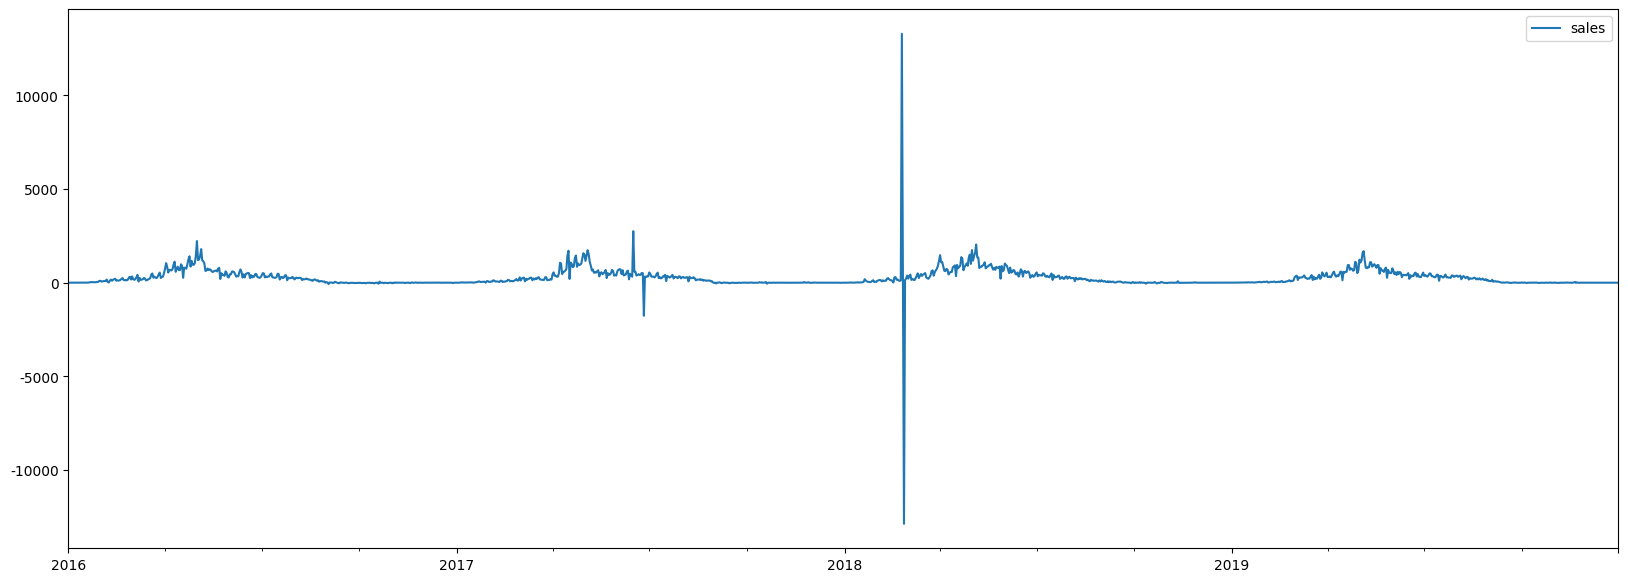

In [18]:
df.plot(figsize=(20, 7))

In [19]:
df[(df['sales']<-1000) | (df['sales']>2500)] = 0

<Axes: >

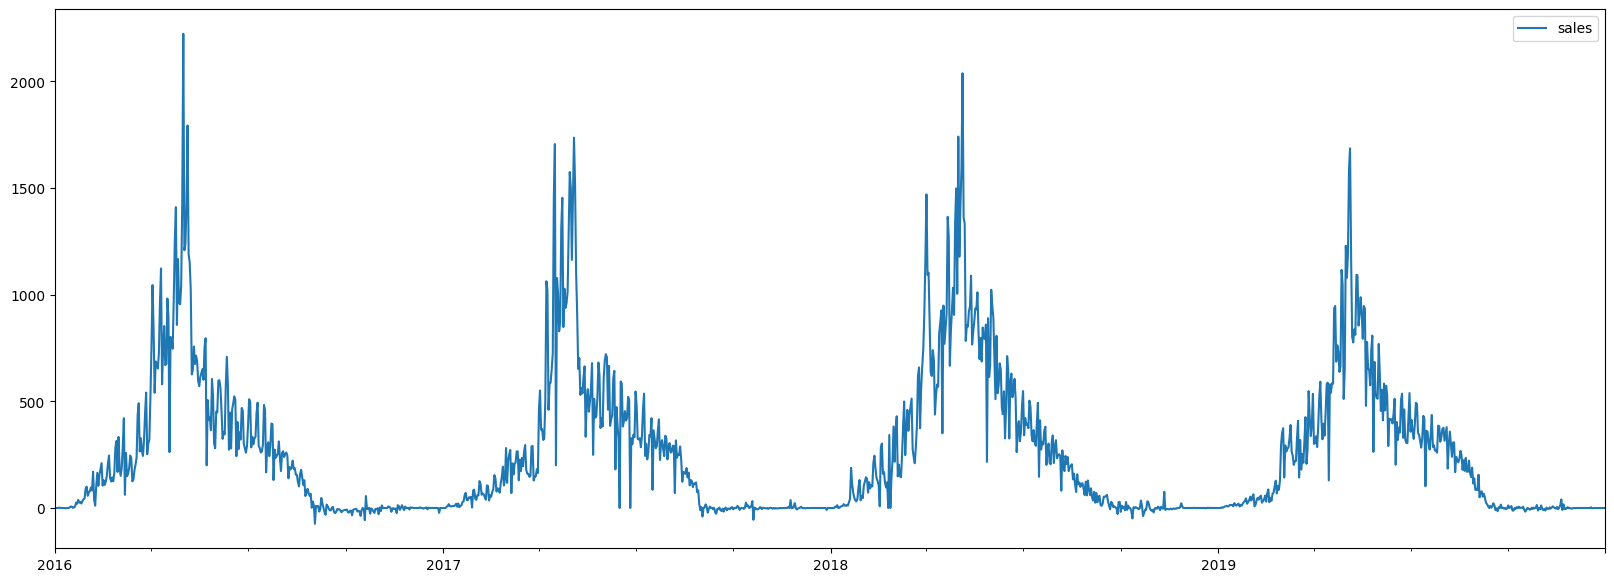

In [20]:
df.plot(figsize=(20, 7))

In [21]:
# 학습데이터는 2019년 여름 시즌 이전까지
train_df = df[:-200]
# 테스트 데이터는 2019년 여름 시즌부터 겨울 시즌전까지 Peak 100일에 대한 예측
test_df = df[-200:-100]

<Axes: >

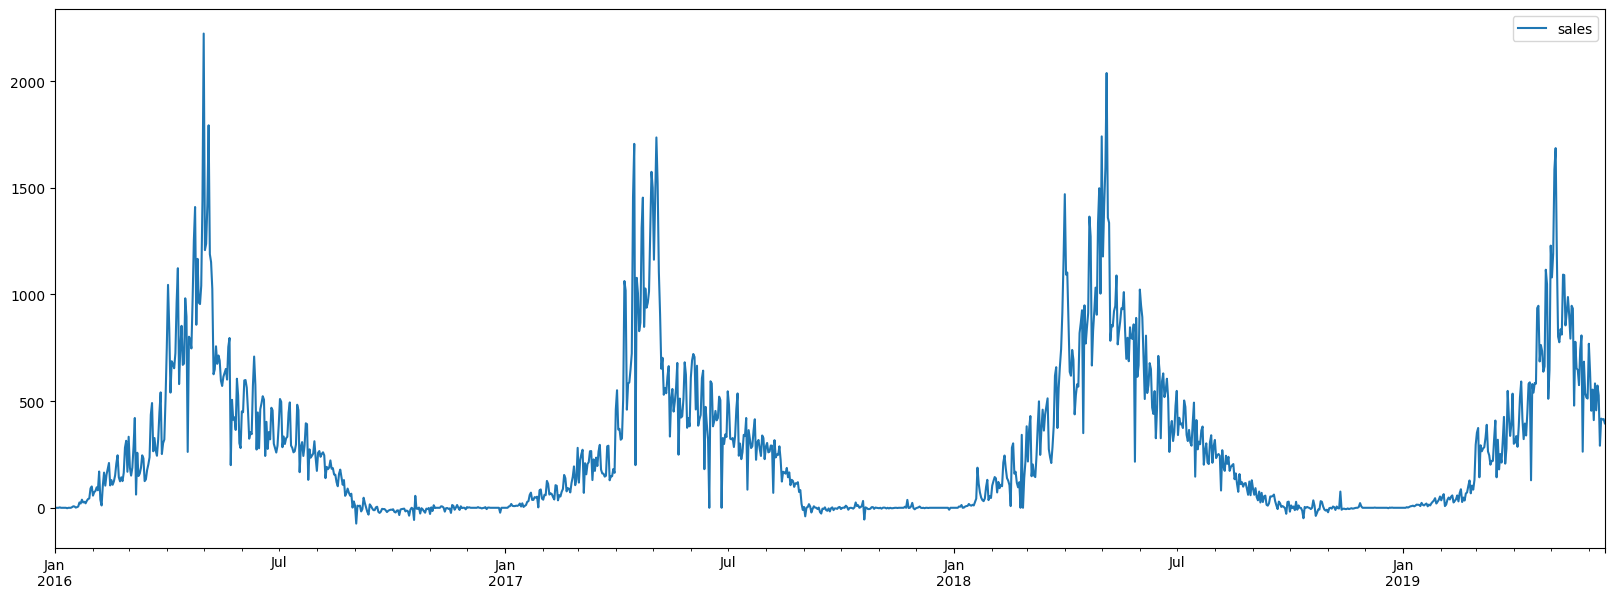

In [22]:
train_df.plot(figsize=(20,7))

<Axes: >

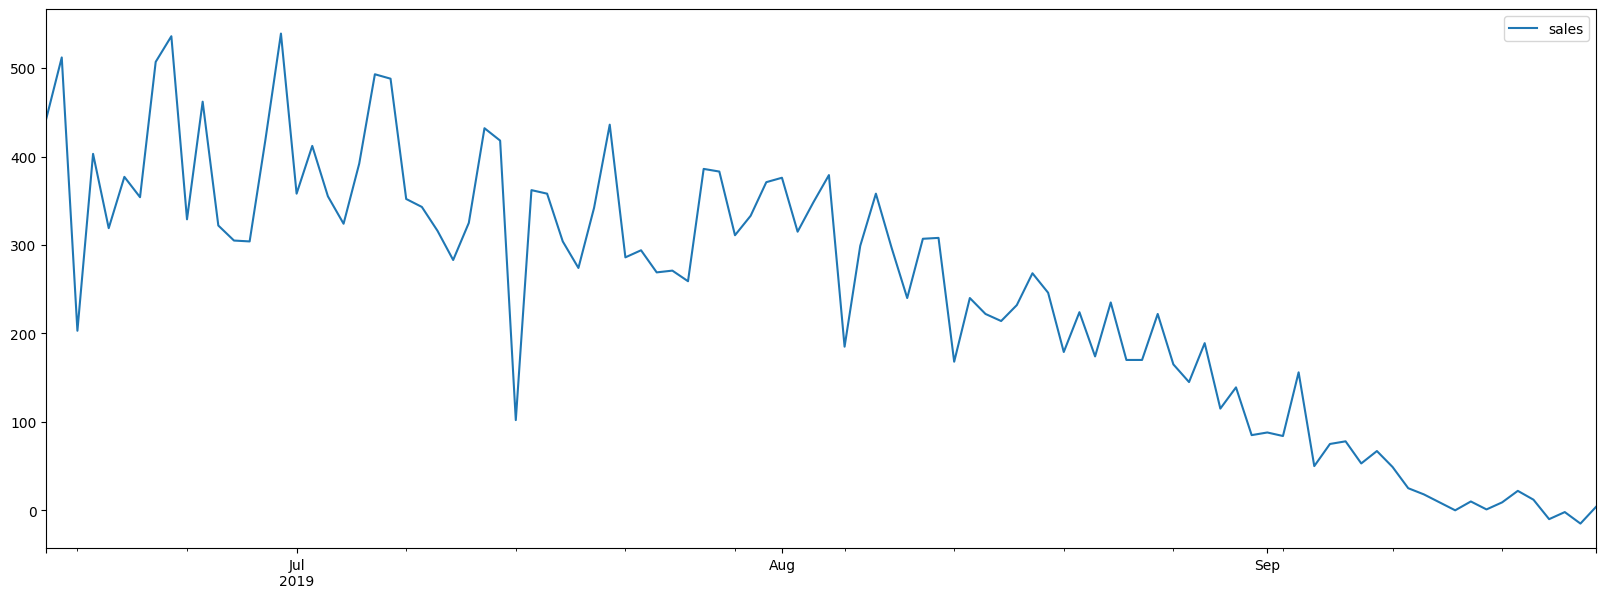

In [23]:
test_df.plot(figsize=(20,7))

# 🥈Session 2
**┗ 시계열 예측 모델링**  
---

## Time series data model using DeepAR

In [24]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
from gluonts.mx.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from pathlib import Path

/usr/local/lib/python3.10/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [25]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    prediction_intervals = (90.0, 50.0)
    legend = ["Sales","observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(20, 7))

    ts_entry.plot(ax=ax)
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

In [ ]:
train_df.head(1)

,sales
2016-01-01,0.0


In [ ]:
test_df.head(1)

,sales
2019-06-15,442.0


In [ ]:
train_df.values.flatten()

array([  0.,   0.,   0., ..., 414., 416., 396.])

In [ ]:
# DeepAR 알고리즘을 사용하기 위해 미리 만들어둔 DataFrame을 ListDataset으로 다시 생성
train_ds = ListDataset([{FieldName.TARGET: train_df.values.flatten(),
                         FieldName.START: pd.Timestamp("2016-01-01 00:00:00", freq='D')
                        }],
                      freq='D')

test_ds = ListDataset([{FieldName.TARGET: test_df.values.flatten(),
                         FieldName.START: pd.Timestamp("2019-06-15 00:00:00", freq='D')
                        }],
                      freq='D')

In [ ]:
test_ds

[{'target': array([442., 512., 203., 403., 319., 377., 354., 507., 536., 329., 462.,
         322., 305., 304., 418., 539., 358., 412., 355., 324., 392., 493.,
         488., 352., 343., 316., 283., 325., 432., 418., 102., 362., 358.,
         304., 274., 342., 436., 286., 294., 269., 271., 259., 386., 383.,
         311., 333., 371., 376., 315., 348., 379., 185., 299., 358., 297.,
         240., 307., 308., 168., 240., 222., 214., 232., 268., 246., 179.,
         224., 174., 235., 170., 170., 222., 165., 145., 189., 115., 139.,
          85.,  88.,  84., 156.,  50.,  75.,  78.,  53.,  67.,  49.,  25.,
          18.,   9.,   0.,  10.,   1.,   9.,  22.,  12., -10.,  -2., -15.,
           4.], dtype=float32), 'start': Period('2019-06-15', 'D')}]

In [ ]:
# 시계열 예측 알고리즘 중 가장 많이 사용되고 있는 DeepAR(AutoRegression) 사용
estimator = DeepAREstimator(
    # 데이터의 주기(D, W, M, Y)
    freq='D',
    # Trainer, cpu | gpu, 학습 반복 횟수,
    trainer=Trainer(ctx="cpu", epochs=30, learning_rate=1E-3, hybridize=True, num_batches_per_epoch=30,),
    # Deeplearning layer 수
    num_layers=4,
    # lstm 셀 갯수
    num_cells=40,
    context_length=30,
    cell_type='lstm', #gru
    # 얼마의 기간에 대해서 예측할 것인가
    prediction_length=30

)
predictor = estimator.train(train_ds) #3.27


100%|██████████| 30/30 [00:08<00:00,  3.73it/s, epoch=30/30, avg_epoch_loss=4.28]


In [ ]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=10,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)



In [ ]:
forecasts[0]

gluonts.model.forecast.SampleForecast(info=None, item_id=None, samples=array([[ 2.07867508e+02,  2.21153717e+02,  7.36095657e+01,
         1.08902092e+02,  1.13557014e+02,  1.27659111e+02,
         6.69544220e+01,  1.04748665e+02,  1.50438126e+02,
         9.34885483e+01,  1.12612160e+02,  1.11297516e+02,
         8.81130676e+01,  1.09835175e+02,  1.04362991e+02,
         1.13706627e+02,  6.34518547e+01,  5.64627419e+01,
         3.34679489e+01,  1.27297506e+01,  4.40740051e+01,
         2.53171082e+01,  1.94112892e+01,  4.40593796e+01,
         3.56833229e+01,  2.20330524e+00, -8.38854313e+00,
        -9.74938393e+00,  2.58049750e+00, -2.39510036e+00],
       [ 2.38083176e+02,  1.92533356e+02,  1.35689087e+02,
         1.18928024e+02,  1.02819717e+02,  1.15685410e+02,
         1.06725647e+02,  8.85569305e+01,  1.63585556e+02,
         1.58304108e+02,  1.28739914e+02,  8.59404984e+01,
         1.05149399e+02,  1.17498917e+02,  1.23077888e+02,
         1.26550690e+02,  8.81357346e+01,  

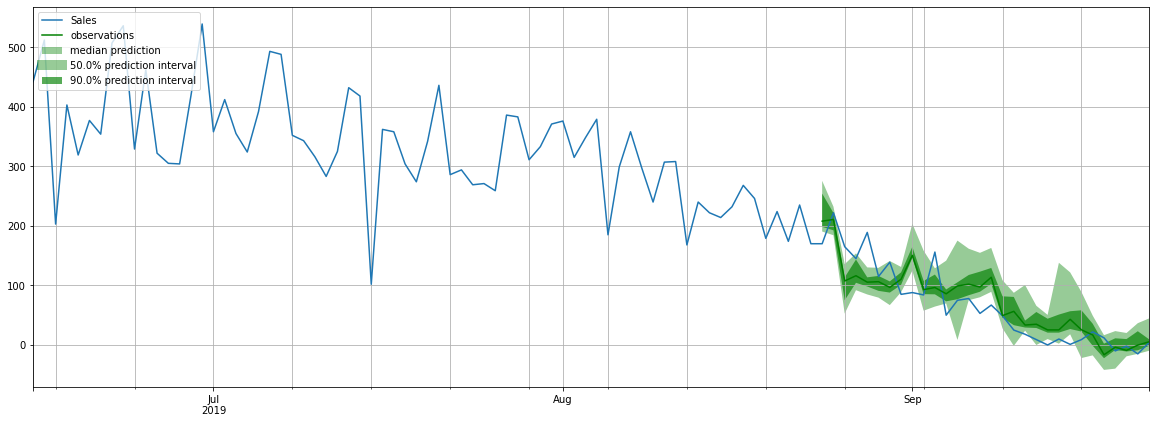

In [ ]:
ts_entry = tss[0]
test_ds_entry = next(iter(test_ds))
forecast_entry = forecasts[0]

plot_prob_forecasts(ts_entry, forecast_entry)

## Time series modeling Error result

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
mean_squared_error(list(forecast_entry.quantile(0.5)), list(ts_entry[0][-30:]), squared=False) #ts_entry# -

34.28276379985972

In [ ]:
mean_absolute_percentage_error(list(forecast_entry.quantile(0.5)), list(ts_entry[0][-30:]))

2.4688160463606423

# 🥇Session 3
**┗ RandomForest 활용 모델링**  
---

## Make a dataset for RandomForestRegressor

In [ ]:
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

def get_slope(array):
    y = np.array(array)
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    return slope

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    return mape

In [ ]:
rdf = df

In [ ]:
rdf

,sales
2016-01-01,0.0
2016-01-02,0.0
2016-01-03,0.0
2016-01-04,0.0
2016-01-05,2.0
...,...
2019-12-27,0.0
2019-12-28,0.0
2019-12-29,0.0
2019-12-30,0.0


In [ ]:
rdf['slope7'] = rdf['sales'].rolling(7).apply(get_slope, raw=True)
rdf['slope21'] = rdf['sales'].rolling(21).apply(get_slope, raw=True)

rdf['std7'] = rdf['sales'].rolling(7).std(raw=True)
rdf['std21'] = rdf['sales'].rolling(21).std(raw=True)

rdf['mean7'] = rdf['sales'].rolling(7).mean(raw=True)
rdf['mean21'] = rdf['sales'].rolling(21).mean(raw=True)

rdf['skew7'] = rdf['sales'].rolling(7).skew()
rdf['skew21'] = rdf['sales'].rolling(21).skew()

rdf['kurt7'] = rdf['sales'].rolling(7).kurt()
rdf['kurt21'] = rdf['sales'].rolling(21).kurt()

rdf['min7'] = rdf['sales'].rolling(7).min()
rdf['min21'] = rdf['sales'].rolling(21).min()

rdf['max7'] = rdf['sales'].rolling(7).max()
rdf['max21'] = rdf['sales'].rolling(21).max()

rdf

,sales,slope7,slope21,std7,std21,mean7,mean21,skew7,skew21,kurt7,kurt21,min7,min21,max7,max21
2016-01-01,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-02,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-03,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-04,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-05,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,0.0,0.0,-0.002597,0.0,0.740013,0.0,0.047619,NaN,3.195566,NaN,14.146539,0.0,-1.0,0.0,3.0
2019-12-28,0.0,0.0,-0.003896,0.0,0.740013,0.0,0.047619,NaN,3.195566,NaN,14.146539,0.0,-1.0,0.0,3.0
2019-12-29,0.0,0.0,-0.005195,0.0,0.740013,0.0,0.047619,NaN,3.195566,NaN,14.146539,0.0,-1.0,0.0,3.0
2019-12-30,0.0,0.0,-0.006494,0.0,0.740013,0.0,0.047619,NaN,3.195566,NaN,14.146539,0.0,-1.0,0.0,3.0


In [ ]:
rdf = rdf[31:-122]
rdf

,sales,slope7,slope21,std7,std21,mean7,mean21,skew7,skew21,kurt7,kurt21,min7,min21,max7,max21
2016-02-01,57.0,10.428571,3.935065,29.668807,28.585461,55.285714,26.142857,0.707934,1.414898,-0.996791,1.687694,21.0,0.0,100.0,100.0
2016-02-02,73.0,7.428571,4.170130,25.927555,29.665597,62.714286,29.619048,0.432936,1.131092,-1.569140,0.591354,33.0,0.0,100.0,100.0
2016-02-03,79.0,4.928571,4.388312,22.779481,30.712337,69.285714,33.380952,-0.009294,0.890337,-1.599134,-0.201782,41.0,0.0,100.0,100.0
2016-02-04,96.0,3.750000,4.724675,20.796062,32.582934,77.142857,37.952381,-0.605401,0.728907,-0.889447,-0.711343,44.0,1.0,100.0,100.0
2016-02-05,82.0,-0.464286,4.797403,14.797040,32.904624,82.571429,41.714286,-0.671901,0.525719,0.109354,-1.088270,57.0,1.0,100.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-27,145.0,-6.250000,-6.789610,32.690468,56.287316,183.000000,227.809524,0.895658,0.599335,-0.546034,-0.107521,145.0,145.0,235.0,358.0
2019-08-28,189.0,-6.892857,-5.433766,32.493223,48.250290,185.142857,219.761905,0.641046,0.395539,-0.840631,-0.665575,145.0,145.0,235.0,308.0
2019-08-29,115.0,-7.285714,-5.690909,33.446475,49.996905,168.000000,211.095238,0.035360,0.224170,0.890255,-0.180060,115.0,115.0,222.0,308.0
2019-08-30,139.0,-10.107143,-6.214286,35.146632,51.899078,163.571429,206.285714,0.431834,0.350925,0.142680,-0.307589,115.0,115.0,222.0,308.0


##Split data into train/test

In [ ]:
y = rdf['sales']
X = rdf.drop('sales', axis=1).fillna(0)
X = X[:-30]
y = y[30:]

train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size = 0.03, random_state = 0, shuffle=False)

MAPE: 65.71938125057815


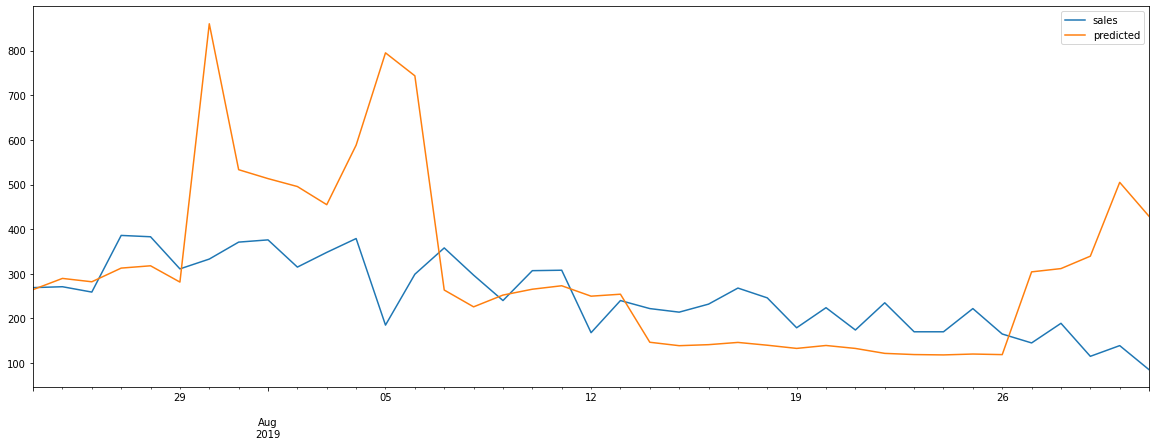

In [ ]:
# Default 세팅으로 RandomForest 학습
rf = RandomForestRegressor(random_state = 0)
rf.fit(train_features, train_labels)
mape = evaluate(rf, test_features, test_labels)
predicted = rf.predict(test_features)
pdf = pd.DataFrame(test_labels)
pdf['predicted'] = predicted
pdf.plot(figsize=(20, 7))
print(f"MAPE: {mape}")

## Tune by hand to decrease underfitting

MAPE: 34.732627167893966


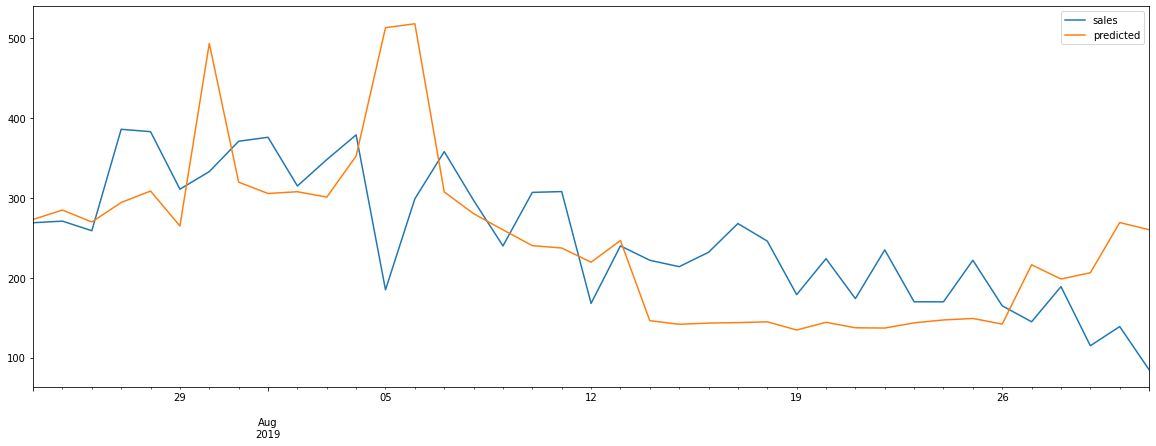

In [ ]:
# Under fitting을 조정하기 위한 n_estimator와 max_features만 조정
rf = RandomForestRegressor(random_state = 0, n_estimators=200, max_features=4)
rf.fit(train_features, train_labels)
mape = evaluate(rf, test_features, test_labels)
predicted = rf.predict(test_features)
pdf = pd.DataFrame(test_labels)
pdf['predicted'] = predicted
pdf.plot(figsize=(20, 7))
print(f"MAPE: {mape}")

## Add more feature to consider additional characteristics

In [ ]:
#해마다 늘어나는 판매량 반영
rdf['year'] = rdf.index.year
#월마다 바뀌는 판매량 반영
rdf['month'] = rdf.index.month
#요일별 판매량 반영
rdf['weekofday'] = rdf.index.dayofweek

y = rdf['sales']
X = rdf.drop('sales', axis=1).fillna(0)
X = X[:-30]
y = y[30:]

train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size = 0.03, random_state = 0, shuffle=False)

MAPE: 20.314733938459025


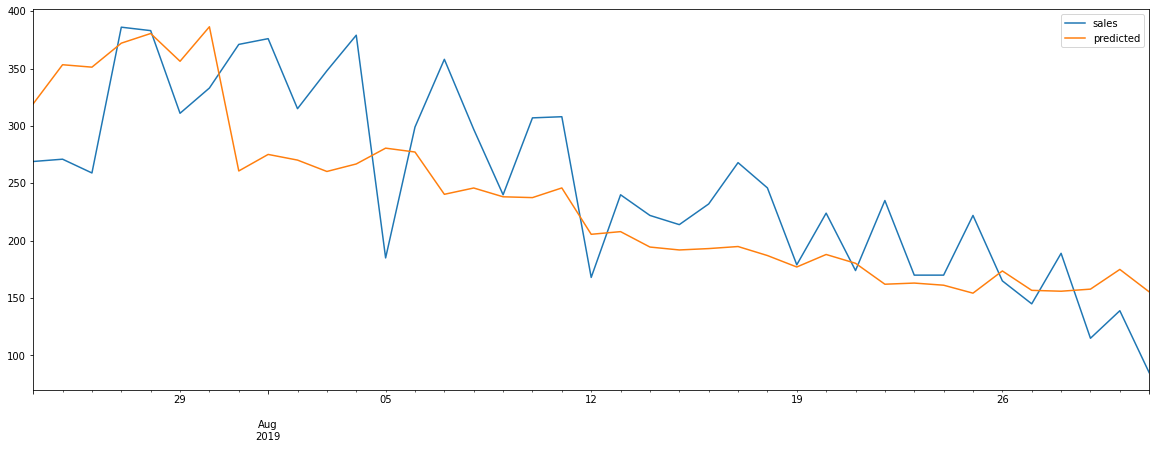

In [ ]:
rf = RandomForestRegressor(random_state = 0, n_estimators=200, max_features=4)
rf.fit(train_features, train_labels)
mape = evaluate(rf, test_features, test_labels)
predicted = rf.predict(test_features)
pdf = pd.DataFrame(test_labels)
pdf['predicted'] = predicted
pdf.plot(figsize=(20, 7))
print(f"MAPE: {mape}")

#Lesson and Learned

## 시계열 분석에서 가장 중요한 부분은 무엇일까?

### 1. 데이터 확인이 무엇보다 중요한 분석이 시계열 분석이다.
### 2. 날짜형 데이터 타입을 다룰 때, 날짜 형식이 데이터 원천에 따라 다를 수 있으므로 날짜 형식을 가장 먼저 확인해야 한다.
### 3. 다음으로는 날짜 사이에 결측이 있는지를 꼭 확인해야 하며, 결측이 있는 경우 학습이 제대로 되지 않을 수 있다.
### 4. RNN을 사용하는 경우, 데이터의 특성을 충분히 반영할 수 있는 hyperparameter를 세팅해야 한다.

## 단변량 데이터로만으로는 시계열의 특성이 반영되지 않는다고 판단될 때,

### 1. 단변량 데이터를 특정 Window size를 기준으로 다변량으로 feature를 생성하여 Regression 방법으로 바꿔볼 수 있다.
### 2. 항상 더 좋은 결과를 기대할 수는 없지만, 본 실습에서의 문제처럼 요일별로 특성을 나타내는 경우에는 효과가 좋다.
### 3. 본 실습에서는 hyperparameter를 DeepAR과 RandomForest 모두 튜닝하지 않았지만 튜닝까지 할 경우 더 나을 결과를 기대할 수 있다.